# 008_DBSCAN_clustering_results_to_device_activity

This script analyzes and processes the results of DBSCAN clustering, which was performed with PySpark and generates data tracking the activity of the top 25% of devices during the Hurricane Harvey. It performs the following tasks:

- identifies presumable home location of each device using temporal k-means clustering
- validate home location results with ACS data
- tracks daily most active cluster during the impact period

In [61]:
# imports
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn.apionly as sns

import folium
from folium.plugins import HeatMap

from scipy.interpolate import make_interp_spline, BSpline
from sklearn import preprocessing

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import geopandas as gpd
from shapely.geometry import Point

from mpl_toolkits.basemap import Basemap

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output
%matplotlib inline

In [62]:
# Check package versions
import types 
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

import pkg_resources
root_packages = [i.split('.', 1)[0] for i in list(imports())] 
for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print (m.project_name, m.version)

seaborn 0.7.1
scipy 1.1.0
pandas 0.23.0
numpy 1.14.3
matplotlib 2.1.0
geopandas 0.3.0
folium 0.5.0


# Load, parse and evaluate DBSCAN clustering results

In [3]:
clusters = pd.read_csv('../data/clusters_top25_users.csv')

In [4]:
clusters.dates_active = [x.replace('[','').replace(' ', '').replace('\n', '').replace(']','')\
                         .replace("'","").split(',') for x in clusters.dates_active]
clusters.hours_active = [[float(h) for h in x.replace('[','').replace(' ', '').replace('\n', '')\
                          .replace(']','').replace("'","").split(',')] for x in clusters.hours_active]

In [5]:
clusters[['labels','ad_id','lat','lon','size','dates_active','hours_active']].head(10)

,labels,ad_id,lat,lon,size,dates_active,hours_active
0,4,5F265B5D-F46D-4F1B-9549-F0E48A60E224,32.455174,-91.509893,2327,"[2016-06-03, 2016-06-07, 2016-06-14, 2016-06-1...","[44.0, 34.0, 7.0, 18.0, 16.0, 22.0, 30.0, 60.0..."
1,2,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,35.397228,-89.630226,2878,"[2016-12-20, 2016-12-21, 2016-12-22, 2016-12-2...","[135.0, 137.0, 139.0, 139.0, 136.0, 134.0, 128..."
2,2,8AF54FB4-BB03-4AFD-9997-D20A5C1637F0,36.627891,-94.814607,5861,"[2016-06-01, 2016-06-02, 2016-06-03, 2016-06-0...","[1.0, 0.0, 0.0, 0.0, 0.0, 78.0, 0.0, 983.0, 92..."
3,1,5F265B5D-F46D-4F1B-9549-F0E48A60E224,32.446467,-91.494068,7239,"[2016-06-03, 2016-06-07, 2016-06-14, 2016-06-1...","[366.0, 332.0, 350.0, 359.0, 335.0, 301.0, 284..."
4,1,8AF54FB4-BB03-4AFD-9997-D20A5C1637F0,36.588276,-94.755402,62052,"[2016-05-31, 2016-06-01, 2016-06-02, 2016-06-0...","[3746.0, 3676.0, 3571.0, 3509.0, 3427.0, 3318...."
5,1,8F1826F3-D253-451F-A238-657AFBB98819,30.050115,-95.385032,48878,"[2016-05-31, 2016-06-01, 2016-06-02, 2016-06-0...","[3023.0, 2976.0, 2885.0, 2880.0, 2891.0, 2597...."
6,6,1355851A-5134-4706-B352-BA15B77F8783,35.190534,-90.052889,1269,"[2016-06-24, 2016-07-03, 2016-07-08, 2016-07-2...","[2.0, 9.0, 12.0, 0.0, 12.0, 12.0, 13.0, 0.0, 1..."
7,1,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,29.968607,-95.209699,76472,"[2016-07-01, 2016-07-02, 2016-07-03, 2016-07-0...","[3311.0, 3321.0, 3338.0, 3328.0, 3334.0, 3382...."
8,3,8AF54FB4-BB03-4AFD-9997-D20A5C1637F0,36.583001,-94.769972,592,"[2016-06-03, 2016-06-07, 2016-06-08, 2016-06-0...","[20.0, 0.0, 28.0, 0.0, 48.0, 0.0, 61.0, 0.0, 4..."
9,4,8F1826F3-D253-451F-A238-657AFBB98819,30.042994,-95.383108,588,"[2016-06-01, 2016-06-02, 2016-06-03, 2016-06-0...","[1.0, 9.0, 0.0, 12.0, 0.0, 4.0, 16.0, 0.0, 13...."


In [6]:
clusters.describe().round(2)

,labels,lat,lon,size
count,541882.00,541882.00,541882.00,541882.00
mean,2.76,31.52,-94.76,1776.35
std,2.12,3.71,7.12,2346.27
min,1.00,19.43,-164.53,21.00
25%,1.00,29.69,-96.83,395.00
50%,2.00,30.05,-95.47,871.00
75%,3.00,32.54,-94.68,2198.00
max,33.00,70.48,-62.05,76472.00


In [7]:
clusters.groupby('labels').describe().round(2)['size'].T.iloc[:, :5]

labels,1,2,3,4,5
count,173683.00,143125.00,89875.00,52714.00,31112.00
mean,3858.30,1289.88,667.76,458.92,356.85
std,3074.55,994.75,481.79,289.11,207.26
min,68.00,47.00,46.00,21.00,39.00
25%,1755.00,602.00,359.00,269.00,214.00
50%,3020.00,1015.00,532.00,392.00,313.00
75%,5069.00,1674.00,820.00,564.00,444.00
max,76472.00,22567.00,9150.00,5199.00,3047.00


In [8]:
clusters.groupby('ad_id').count().describe()['labels'].round(2)

count    173683.00
mean          3.12
std           2.09
min           1.00
25%           2.00
50%           3.00
75%           4.00
max          33.00
Name: labels, dtype: float64

# Spatial visualization of the clusters

based on https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf

In [9]:
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=9):
    # define 
    base_map = folium.Map(location=default_location, control_scale=True, 
                          zoom_start=default_zoom_start, tiles='cartodbpositron')
    return base_map

In [14]:
base_map = generateBaseMap(default_location=[29.744088, -95.364310])

# add 3 layers for 3 biggest clusters
cluster_1 = HeatMap(data=clusters.sample(frac=0.05)[clusters.labels==1][['lat', 'lon']]\
                    .reset_index(drop=True).values.tolist(), 
        radius=8, 
        name='cluster 1',
        max_zoom=13)

cluster_2 = HeatMap(data=clusters.sample(frac=0.05)[clusters.labels==2][['lat', 'lon']]\
                    .reset_index(drop=True).values.tolist(), 
        radius=8, 
        name='cluster 2',
        max_zoom=13)

cluster_3 = HeatMap(data=clusters.sample(frac=0.05)[clusters.labels==3][['lat', 'lon']]\
                    .reset_index(drop=True).values.tolist(), 
        radius=8, 
        name='cluster 3',
        max_zoom=13)

base_map.add_children(cluster_1)
base_map.add_children(cluster_2)
base_map.add_children(cluster_3)

# add layer control functionality
folium.LayerControl().add_to(base_map)

# show visualization
base_map

# Grouping activity clusters based on their hourly activity profile 

### Evaluate cluster's hourly activity profiles

In [15]:
hours = pd.DataFrame(data=clusters.hours_active.tolist())
hours_norm = hours.div(hours.max(axis=1), axis=0)

Text(0,0.5,'frequency')

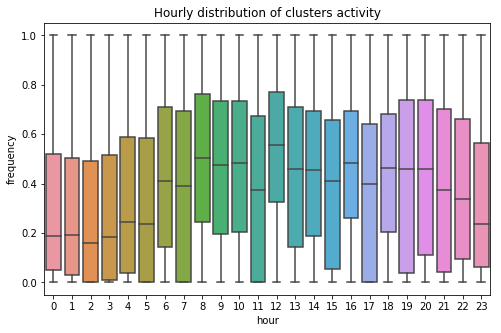

In [16]:
fig, ax = plt.subplots(1, figsize=(8,5))

sns.boxplot(data=hours_norm, ax=ax)

plt.title('Hourly distribution of clusters activity')
plt.xlabel('hour')
plt.ylabel('frequency')

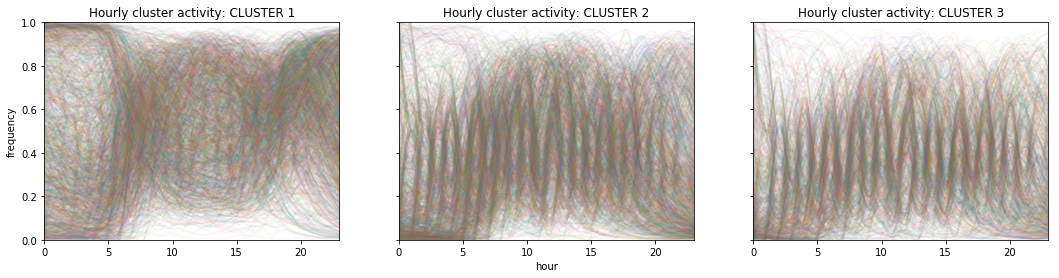

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(18,4), sharey=True)

xnew = np.linspace(0, 23, 300) 

for i in range(1,4):
    for n, c in enumerate(clusters[clusters.labels==i].sample(frac=0.01)['hours_active']):
        spl = make_interp_spline(range(24), pd.DataFrame(data=[float(i)/max(c) for i in c])\
                                 .ewm(span=3, adjust=False).mean(), \
                                 k=2)  # type: BSpline
        power_smooth = spl(xnew)

        ax[i-1].plot(xnew, power_smooth, alpha=0.05)
        ax[i-1].set_ylim(0,1)
        ax[i-1].set_xlim(0,23)
        ax[i-1].set_title('Hourly cluster activity: CLUSTER {}'.format(i))
        
        if i-1 ==1:
            ax[i-1].set_xlabel('hour')
        if i-1 ==0:
            ax[i-1].set_ylabel('frequency')

### Clustering timeseries with k-means
based on https://www.influxdata.com/blog/why-use-k-means-for-time-series-data-part-two/

Apply Exponential Weighted Function to smooth out timeseries

In [18]:
def ewm(line):
    spl = make_interp_spline(range(24), pd.DataFrame(data=line).ewm(span=3, adjust=False).mean(), k=1)
    ewm = spl(range(24))
    return np.concatenate(ewm).ravel()

In [19]:
hours_ewm = pd.DataFrame(hours_norm.apply(lambda x: ewm(x), axis=1))
hours_ewm = pd.DataFrame(data=hours_ewm[0].tolist())

In [20]:
# Timeseries with numpy array
times_ewm_array = hours_ewm.as_matrix()
times_ewm_array.shape

(541882, 24)

In [21]:
# K means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(times_ewm_array)
    distortions.append(sum(np.min(cdist(times_ewm_array, kmeanModel.cluster_centers_, \
                                        'euclidean'), axis=1))/times_ewm_array.shape[0])


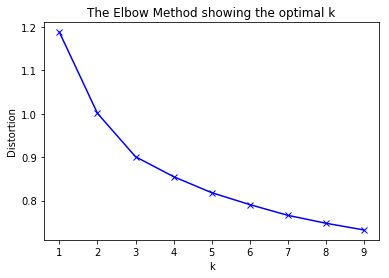

In [22]:
# Plot elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [23]:
kmeanModel = KMeans(n_clusters=4, random_state=1987).fit(times_ewm_array)

### Results of k-means clustering of activity hourly profiles

In [24]:
results = clusters.copy()
results['kmeans'] = kmeanModel.labels_

In [25]:
# generate daily activation matrix
for d in pd.date_range(datetime.datetime.strptime('2017-08-01', '%Y-%m-%d'), \
                       datetime.datetime.strptime('2017-10-27', '%Y-%m-%d'), freq='D'):
    date = datetime.datetime.strftime(d, '%Y-%m-%d')
    print(date)
    results[date] = results.dates_active.apply(lambda x: 1 if date in x else 0)
    clear_output(wait=True)

2017-10-27


In [26]:
# apply characteristics
results['number_of_days'] = results.dates_active.apply(lambda x: len(x))
results['days_of_week'] = [[float(datetime.datetime.strptime(h, '%Y-%m-%d').weekday()) for h in x] \
                           for x in results.dates_active]
results['weekends'] = results.days_of_week.apply(lambda x: sum(np.array(x)>4))
results['weekend_ratio'] = results['weekends'].astype(float) / results['number_of_days'] 

In [27]:
# results.to_csv('../../data/clusters_top25_users_with_kmeans_Aug_Oct_2017.csv', index=False)

Text(0,0.5,'weekend ratio')

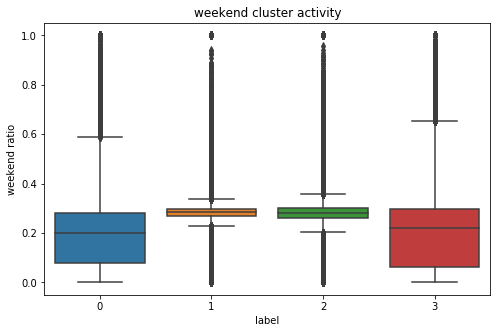

In [28]:
# explore which clusters were associated more with weekend activity
fig, ax = plt.subplots(1, figsize=(8,5))
sns.boxplot(data=results, x='kmeans', y='weekend_ratio', ax=ax)
plt.title('weekend cluster activity')
plt.xlabel('label')
plt.ylabel('weekend ratio')

In [29]:
results.groupby('kmeans').describe()['labels']

,count,mean,std,min,25%,50%,75%,max
kmeans,,,,,,,,
0,125441.0,2.794589,1.826961,1.0,2.0,2.0,3.0,28.0
1,86348.0,1.522027,1.052102,1.0,1.0,1.0,2.0,19.0
2,134957.0,1.918619,1.448881,1.0,1.0,1.0,2.0,22.0
3,195136.0,3.870808,2.449815,1.0,2.0,3.0,5.0,33.0


Text(0.5,1,'Results of k-means clustering of DBSCAN cluster hourly activity profiles (k=4)')

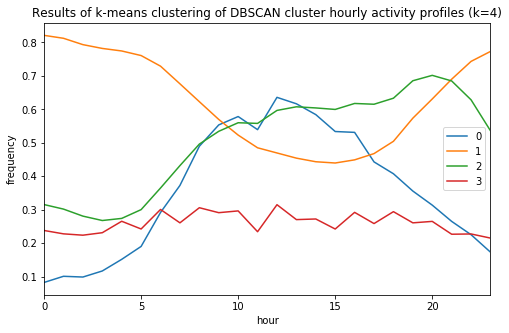

In [40]:
pd.DataFrame(kmeanModel.cluster_centers_.T).plot(figsize=(8,5))
plt.xlim(0,23)
plt.xlabel('hour')
plt.ylabel('frequency')
plt.title('Results of k-means clustering of DBSCAN cluster hourly activity profiles (k=4)')

### k-means clustering results interpretation

The resulting 4 clusters illustrate various hourly activity profiles of the areas of activity (clusters identified  by DBSCAN algorithm). They can be associated with various behaviors and activity types. For the purpose of this study we assume that:
- cluster 0 (blue) - is associated with regular work locations with the activity rising in the morning and decreasing in the afternoon with a slight dip around noon related to the lunch break: **CLASS: WORK, home location probability: LOW**
- cluster 1 (yellow) - is associated with mostly with home activity, as an inverse of cluster 0. The activity is the highest in the evening hours, decreasing as we approach morning ruch hours and increasing again in the afternoon. It has also significant proportion of the weekend activity. **CLASS: HOME, home location probability: VERY HIGH**
- cluster 2 (green) - is associated with popular places of activity (CBDs) with many work places as well as entertainment, shopping and gastronomic establishments, where activity is high during the day but the maximum levels falls in the evening, ater which decrease dramatically. **CLASS: POPULAR SPOTS, home location probability: LOW to MODERATE**
- cluster 3 (red) - mixed use areas with relatively stable levels of activity throughout the day on various days of the week. It contain both work place, entertainment and residential areas. **CLASS: MIXED, home location probability: MODERATE to HIGH**

# Home location identification
Based on the k-means clustering results, each device will be assigned home location to one of its clusters of activity based on the presumed probabilities described above.

### Generate home location data frame

In [41]:
users_ids = pd.DataFrame(data=results.ad_id.unique(), columns=['ad_id'])
users_ids.shape

(173683, 1)

In [42]:
homes = users_ids.merge(results[results.kmeans==1][['ad_id','lat', 'lon', 'size', 'labels', 'kmeans', 'weekend_ratio']], how='left')
print(homes.shape)
homes = homes.sort_values(by=['ad_id','size'], ascending=False).drop_duplicates(subset='ad_id', keep='first')
print(homes.shape)

(192046, 7)
(173683, 7)


In [43]:
missing_subset = homes[homes.kmeans.isnull()]
print(missing_subset.shape)
homes.dropna(subset=['kmeans'], inplace=True)
print(homes.shape)

(105698, 7)
(67985, 7)


In [44]:
missing_subset = missing_subset[['ad_id']].merge(results[results.kmeans==2][['ad_id','lat', 'lon', 'size', 'labels', 'kmeans', 'weekend_ratio']], how='left')
print(missing_subset.shape)
missing_subset = missing_subset.sort_values(by=['ad_id','size'], ascending=False).drop_duplicates(subset='ad_id', keep='first')
print(missing_subset.shape)

(138299, 7)
(105698, 7)


In [45]:
homes = pd.concat([homes, missing_subset])
print(homes.dropna(subset=['kmeans']).shape)

(146459, 7)


In [46]:
missing_subset = homes[homes.kmeans.isnull()]
print(missing_subset.shape)
homes.dropna(subset=['kmeans'], inplace=True)
print(homes.shape)

(27224, 7)
(146459, 7)


In [47]:
missing_subset = missing_subset[['ad_id']].merge(results[results.kmeans==3][['ad_id','lat', 'lon', 'size', 'labels', 'kmeans', 'weekend_ratio']], how='left')
print(missing_subset.shape)
missing_subset = missing_subset.sort_values(by=['ad_id','size'], ascending=False).drop_duplicates(subset='ad_id', keep='first')
print(missing_subset.shape)

(49250, 7)
(27224, 7)


In [48]:
homes = pd.concat([homes, missing_subset])
print(homes.dropna(subset=['kmeans']).shape)

(167866, 7)


In [49]:
missing_subset = homes[homes.kmeans.isnull()]
print(missing_subset.shape)
homes.dropna(subset=['kmeans'], inplace=True)
print(homes.shape)

(5817, 7)
(167866, 7)


In [50]:
missing_subset = missing_subset[['ad_id']].merge(results[results.kmeans==0][['ad_id','lat', 'lon', 'size', 'labels', 'kmeans', 'weekend_ratio']], how='left')
print(missing_subset.shape)
missing_subset = missing_subset.sort_values(by=['ad_id','size'], ascending=True).drop_duplicates(subset='ad_id', keep='first')
print(missing_subset.shape)

(9486, 7)
(5817, 7)


In [51]:
homes = pd.concat([homes, missing_subset])
print(homes.dropna(subset=['kmeans']).shape)

(173683, 7)


In [52]:
homes.describe()

,lat,lon,size,labels,kmeans,weekend_ratio
count,173683.000000,173683.000000,173683.00000,173683.000000,173683.000000,173683.000000
mean,31.495399,-94.806648,3555.00798,1.258056,1.664838,0.276158
std,3.674496,7.008646,3148.27515,0.689148,0.732340,0.068972
min,19.428203,-159.366539,68.00000,1.000000,0.000000,0.000000
25%,29.683334,-96.806581,1360.00000,1.000000,1.000000,0.264398
50%,30.049551,-95.488692,2667.00000,1.000000,2.000000,0.280000
75%,32.507531,-94.809662,4822.00000,1.000000,2.000000,0.291971
max,70.345690,-63.514914,76472.00000,15.000000,3.000000,1.000000


In [53]:
homes.head()

,ad_id,lat,lon,size,labels,kmeans,weekend_ratio
164517,FFFFB84F-8335-49EC-8D15-581CD7F8278E,42.976038,-88.021835,5645.0,1.0,1.0,0.280967
38929,FFFF4B56-F2F2-4742-A6EC-E454048A6798,29.339138,-95.790211,2663.0,1.0,1.0,0.256545
89266,FFFF09BD-06B7-446D-BCDC-AA0FC2B7A3D5,30.199057,-97.302342,1515.0,1.0,1.0,0.275862
68216,FFFE1667-1A8A-4387-9490-046BB1556A24,28.711844,-96.206561,3562.0,1.0,1.0,0.285714
164923,FFFD7299-C21E-469B-BF34-CBBA64251CE1,30.121188,-95.546882,7596.0,1.0,1.0,0.267148


### Validation of home location identification

In [55]:
# Load ACS CT shapefile data
ct_shp = gpd.read_file('../../data/Houston_CT_SHP/Houston.shp')
ct_shp.GEOID = ct_shp.GEOID.astype(int)
ct_shp.to_crs({'init': u'epsg:4326'}, inplace=True)
print(ct_shp.shape)
ct_shp.head()

,OBJECTID,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,GEOID_Data,geometry
0,1,48,201,542301,48201542301,5423.01,Census Tract 5423.01,G5020,S,5956745.0,15456.0,+29.8204990,-095.7316493,0.107877,0.000557,14000US48201542301,POLYGON ((-95.75223799988373 29.83168599970918...
1,2,48,157,673800,48157673800,6738,Census Tract 6738,G5020,S,14100074.0,1008190.0,+29.5874575,-095.7125243,0.213312,0.001407,14000US48157673800,POLYGON ((-95.75838600011377 29.58353099985579...
2,3,48,157,674000,48157674000,6740,Census Tract 6740,G5020,S,4826110.0,65291.0,+29.5869509,-095.6224534,0.083878,0.000455,14000US48157674000,POLYGON ((-95.63467300035865 29.58952500017864...
3,4,48,157,674100,48157674100,6741,Census Tract 6741,G5020,S,4170610.0,0.0,+29.5791692,-095.5995891,0.081921,0.000388,14000US48157674100,POLYGON ((-95.61466699958231 29.57828199971459...
4,5,48,201,552601,48201552601,5526.01,Census Tract 5526.01,G5020,S,2911911.0,4263.0,+29.9629845,-095.5679180,0.087279,0.000273,14000US48201552601,POLYGON ((-95.58524099967235 29.96622599963024...


In [56]:
# Load Texas ACS population data
ct_acs = pd.read_csv('../../data/acs_houston_ct/independent variables - acs.csv')
ct_acs.Id2 = ct_acs.Id2.astype(int)
print(ct_acs.shape)
ct_acs.head()

(786, 43)


,Id,Id2,pop,pct_pop_age_lt_18,pct_pop_age_18_30,pct_pop_age_gt_65,med_building_age,pct_hh_computer,pct_pop_disability,pct_high_edu,...,pct_hh_income_25_75k,pct_hh_income_gt_75k,med_income,pct_hh_no_internet,pct_hh_poverty,med_room,pct_pop_unemp,pct_hu_vacant,pct_hh_vehicle,pct_pop_veteran
0,1400000US48201100000,48201100000,4712,0.020374,0.210314,0.062818,52.0,0.955337,0.129,0.265,...,0.009558,0.026842,98508.0,0.100491,0.000,2.7,0.053,0.260568,0.843234,0.104
1,1400000US48201210100,48201210100,6252,0.016475,0.437460,0.008477,40.0,1.000000,0.229,0.014,...,0.103947,1.211842,175714.0,0.000000,0.000,4.5,0.000,0.136364,1.000000,0.042
2,1400000US48201210400,48201210400,4556,0.297849,0.165716,0.141352,72.0,0.609074,0.141,0.014,...,0.021318,0.008888,24473.0,0.483530,0.374,4.5,0.067,0.115448,0.742697,0.024
3,1400000US48201210500,48201210500,5649,0.279518,0.197734,0.094884,62.0,0.771769,0.147,0.036,...,0.027528,0.007193,33426.0,0.333153,0.259,4.9,0.138,0.095401,0.852893,0.048
4,1400000US48201210600,48201210600,5289,0.238419,0.165060,0.104368,69.0,0.939647,0.121,0.093,...,0.019480,0.016928,51295.0,0.134446,0.173,5.5,0.040,0.098230,0.923945,0.056


In [57]:
# merge Shapfile with population information
ct_pop = ct_shp.merge(ct_acs[['Id2','pop']], left_on='GEOID', right_on='Id2', how='inner')
ct_pop.drop(labels='Id2', inplace=True, axis=1)
print(ct_pop.shape)
ct_pop.head()

(786, 18)


,OBJECTID,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,GEOID_Data,geometry,pop
0,1,48,201,542301,48201542301,5423.01,Census Tract 5423.01,G5020,S,5956745.0,15456.0,+29.8204990,-095.7316493,0.107877,0.000557,14000US48201542301,POLYGON ((-95.75223799988373 29.83168599970918...,14462
1,5,48,201,552601,48201552601,5526.01,Census Tract 5526.01,G5020,S,2911911.0,4263.0,+29.9629845,-095.5679180,0.087279,0.000273,14000US48201552601,POLYGON ((-95.58524099967235 29.96622599963024...,6042
2,13,48,201,323701,48201323701,3237.01,Census Tract 3237.01,G5020,S,2311213.0,5694.0,+29.6551252,-095.1769249,0.057990,0.000216,14000US48201323701,POLYGON ((-95.18667400000506 29.66507100002667...,4411
3,14,48,201,240501,48201240501,2405.01,Census Tract 2405.01,G5020,S,3284070.0,1111.0,+29.9582552,-095.3914922,0.071532,0.000307,14000US48201240501,POLYGON ((-95.40366299974761 29.96597299965424...,5973
4,15,48,201,240701,48201240701,2407.01,Census Tract 2407.01,G5020,S,7409441.0,3498.0,+30.0113158,-095.4162249,0.110578,0.000693,14000US48201240701,POLYGON ((-95.42898200001923 30.02115200006483...,14863


In [58]:
# Apply geometry to homes data frame
geometry = [Point(xy) for xy in zip(homes.lon, homes.lat)]
crs = {'init': 'epsg:4326'}
homes = gpd.GeoDataFrame(homes, crs=crs, geometry=geometry)
print(homes.shape)
homes.head()

(173683, 8)


,ad_id,lat,lon,size,labels,kmeans,weekend_ratio,geometry
164517,FFFFB84F-8335-49EC-8D15-581CD7F8278E,42.976038,-88.021835,5645.0,1.0,1.0,0.280967,POINT (-88.0218351685 42.9760384496)
38929,FFFF4B56-F2F2-4742-A6EC-E454048A6798,29.339138,-95.790211,2663.0,1.0,1.0,0.256545,POINT (-95.7902112535 29.3391378825)
89266,FFFF09BD-06B7-446D-BCDC-AA0FC2B7A3D5,30.199057,-97.302342,1515.0,1.0,1.0,0.275862,POINT (-97.3023419531 30.1990565743)
68216,FFFE1667-1A8A-4387-9490-046BB1556A24,28.711844,-96.206561,3562.0,1.0,1.0,0.285714,POINT (-96.2065608832 28.7118439978)
164923,FFFD7299-C21E-469B-BF34-CBBA64251CE1,30.121188,-95.546882,7596.0,1.0,1.0,0.267148,POINT (-95.54688186360001 30.121188067)


In [66]:
# Perform spatial join of homes location and Census Tract level ACS data
ct_homes = gpd.sjoin(ct_pop, homes, how='left')
ct_homes.rename(columns={'OBJECTID_x':'OBJECTID'}, inplace=True)

ct_pop = ct_pop.merge(ct_homes.groupby('GEOID')['OBJECTID'].count().reset_index(), how='left', on='GEOID')
ct_pop.rename(columns={'OBJECTID_y':'home_num'}, inplace=True)

# calculate z-score for each CT level population for ACS and DBSCAN estimation
ct_pop['pop_25pct'] = ct_pop['pop']*.25
ct_pop['pop_z'] = stats.zscore(ct_pop['pop'])
ct_pop['home_num_z'] = stats.zscore(ct_pop['home_num'])
ct_pop['z_diff'] = ct_pop.pop_z - ct_pop.home_num_z

Text(0.05,0.9,"Pearson's R: 0.73\nn: 786")

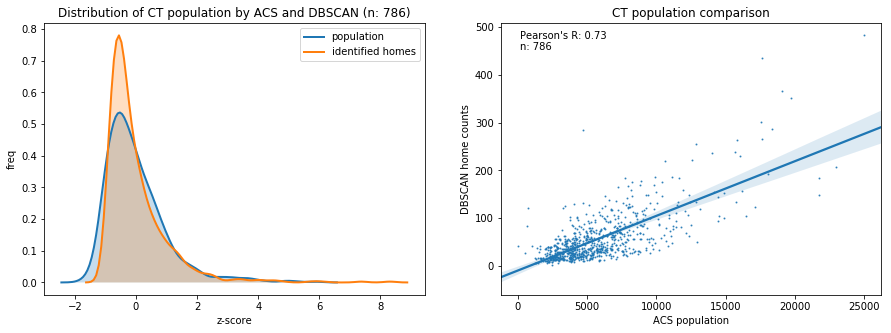

In [67]:
fig, ax = plt.subplots(figsize=(15,5),ncols=2,nrows=1)

sns.distplot(ct_pop['pop_z'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2}, label='population', ax=ax[0])

sns.distplot(ct_pop['home_num_z'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2}, label='identified homes', ax=ax[0])

ax[0].set_xlabel('z-score')
ax[0].set_ylabel('freq')
ax[0].legend()
ax[0].set_title('Distribution of CT population by ACS and DBSCAN (n: {})'.format(len(ct_pop)))

# ax[1].scatter(ct_pop['pop'], ct_pop['home_num'],s=1)
sns.regplot(x="pop", y="home_num", data=ct_pop, ax=ax[1], scatter_kws={'s':1})
ax[1].set_title('CT population comparison')
ax[1].set_xlabel('ACS population')
ax[1].set_ylabel('DBSCAN home counts')
ax[1].text(0.05, 0.9, "Pearson's R: {:.2f}\nn: {}".format(stats.pearsonr(ct_pop['pop'].values, ct_pop.home_num.values)[0],
                                                       len(ct_pop)),
           transform=ax[1].transAxes)

Text(0.5,1,'CT population Z score difference for ACS and DBSCAN')

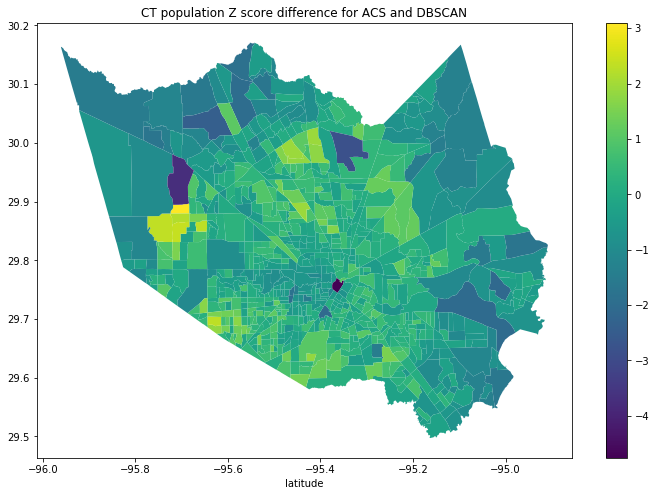

In [69]:
# plot CT level z-score population differences 
fig, ax = plt.subplots(figsize=(12,8))

union = ct_pop.unary_union

# m = Basemap(projection='cyl', ellps='WGS84',
#             llcrnrlon=round(bbox.bounds[0], 1), llcrnrlat=round(bbox.bounds[1], 1), \
#             urcrnrlon=round(bbox.bounds[2], 1), urcrnrlat=round(bbox.bounds[3], 1),
# #             llcrnrlon=-130, llcrnrlat=15, urcrnrlon=-65, urcrnrlat=50,
#             resolution='c', suppress_ticks=False)

# m.arcgisimage(service='Canvas/World_Dark_Gray_Base', xpixels = 1000, verbose= True)

ct_pop.plot(column='z_diff', legend=True, ax=ax)
ax.set_xlabel('longitude')
ax.set_xlabel('latitude')
ax.set_title('CT population Z score difference for ACS and DBSCAN')

# Tracking evacuation

In [133]:
evac = users_ids.copy()
evac = evac.merge(homes[['ad_id', 'lat', 'lon']], how='left')
evac.columns=[np.array(['id', 'home', 'home']), np.array(['ad_id', 'lat', 'lon'])]

In [134]:
evac.head()

id       home           
                                  ad_id        lat        lon
0  5F265B5D-F46D-4F1B-9549-F0E48A60E224  32.446467 -91.494068
1  0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02  29.968607 -95.209699
2  8AF54FB4-BB03-4AFD-9997-D20A5C1637F0  36.588276 -94.755402
3  8F1826F3-D253-451F-A238-657AFBB98819  30.050115 -95.385032
4  1355851A-5134-4706-B352-BA15B77F8783  36.087519 -88.601156

In [135]:
results.iloc[:, 8:96].columns

Index(['2017-08-01', '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
       '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-10',
       '2017-08-11', '2017-08-12', '2017-08-13', '2017-08-14', '2017-08-15',
       '2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19', '2017-08-20',
       '2017-08-21', '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
       '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30',
       '2017-08-31', '2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04',
       '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08', '2017-09-09',
       '2017-09-10', '2017-09-11', '2017-09-12', '2017-09-13', '2017-09-14',
       '2017-09-15', '2017-09-16', '2017-09-17', '2017-09-18', '2017-09-19',
       '2017-09-20', '2017-09-21', '2017-09-22', '2017-09-23', '2017-09-24',
       '2017-09-25', '2017-09-26', '2017-09-27', '2017-09-28', '2017-09-29',
       '2017-09-30', '2017-10-01', '2017-10-02', '2017-10-03', '2017-10-04',

In [136]:
for c in results.iloc[:, 8:96].columns:
    print(c)
    activity_1 = results[['ad_id', 'lat', 'lon', 'size', 'kmeans', c]][(results[c]==1)&(results['kmeans']==1)].sort_values(by=['ad_id', 'size'], ascending=False).drop_duplicates(subset='ad_id', keep='first')

    activity_0 = results[['ad_id', 'lat', 'lon', 'size', 'kmeans', c]][(results[c]==1)&(results['kmeans']==2)].sort_values(by=['ad_id', 'size'], ascending=False).drop_duplicates(subset='ad_id', keep='first')

    activity_3 = results[['ad_id', 'lat', 'lon', 'size', 'kmeans', c]][(results[c]==1)&(results['kmeans']!=1)&(results['kmeans']!=2)].sort_values(by=['ad_id', 'size'], ascending=False).drop_duplicates(subset='ad_id', keep='first')

    combined = pd.concat([activity_1,activity_0,activity_3]).drop_duplicates(subset='ad_id', keep='first')[['ad_id','lat','lon']]
    combined.columns = [np.array([c,c,c]), np.array(['ad_id', 'lat', 'lon'])]
    
    evac = evac.merge(combined, how='left', left_on=[('id', 'ad_id')], right_on=[(c, 'ad_id')])
    evac.drop((c, 'ad_id'), axis=1, inplace=True)
    clear_output(wait=True)

2017-10-27


In [137]:
evac.head()

id       home            2017-08-01  \
                                  ad_id        lat        lon        lat   
0  5F265B5D-F46D-4F1B-9549-F0E48A60E224  32.446467 -91.494068        NaN   
1  0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02  29.968607 -95.209699  29.968607   
2  8AF54FB4-BB03-4AFD-9997-D20A5C1637F0  36.588276 -94.755402  36.588276   
3  8F1826F3-D253-451F-A238-657AFBB98819  30.050115 -95.385032        NaN   
4  1355851A-5134-4706-B352-BA15B77F8783  36.087519 -88.601156  35.061378   

             2017-08-02            2017-08-03             2017-08-04 ...  \
         lon        lat        lon        lat         lon        lat ...   
0        NaN        NaN        NaN        NaN         NaN        NaN ...   
1 -95.209699  29.968607 -95.209699  29.968607  -95.209699  29.968607 ...   
2 -94.755402  36.588276 -94.755402  36.588276  -94.755402  36.588276 ...   
3        NaN  30.050115 -95.385032  30.050115  -95.385032  30.050115 ...   
4 -90.028815        NaN        NaN  39.828694 -104.924599  45.920075 ...   

  2017-10-23            2017-10-24            2017-10-25             \
         lat        lon        lat        lon        lat        lon   
0        NaN        NaN        NaN        NaN        NaN        NaN   
1  29.968607 -95.209699  29.968607 -95.209699  29.968607 -95.209699   
2  36.588276 -94.755402  36.588276 -94.755402  36.588276 -94.755402   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

  2017-10-26            2017-10-27      
         lat        lon        lat lon  
0        NaN        NaN        NaN NaN  
1        NaN        NaN        NaN NaN  
2  36.588276 -94.755402        NaN NaN  
3        NaN        NaN        NaN NaN  
4        NaN        NaN        NaN NaN  

[5 rows x 179 columns]

In [138]:
evac.describe()

home                    2017-08-01                 \
                 lat            lon            lat            lon   
count  173683.000000  173683.000000  134712.000000  134712.000000   
mean       31.495399     -94.806648      31.400304     -94.890887   
std         3.674496       7.008646       3.588454       6.781488   
min        19.428203    -159.366539      19.428203    -159.484241   
25%        29.683334     -96.806581      29.680835     -96.797404   
50%        30.049551     -95.488692      30.034772     -95.494678   
75%        32.507531     -94.809662      32.215683     -94.924051   
max        70.345690     -63.514914      70.345690     -62.553528   

          2017-08-02                    2017-08-03                 \
                 lat            lon            lat            lon   
count  136462.000000  136462.000000  136648.000000  136648.000000   
mean       31.364789     -94.898823      31.378801     -94.884334   
std         3.548276       6.692082       3.559934       6.713932   
min        19.428203    -159.484241      19.428203    -164.528197   
25%        29.680459     -96.773064      29.680439     -96.784361   
50%        30.028853     -95.494445      30.031807     -95.494327   
75%        32.008078     -94.937241      32.050066     -94.926680   
max        70.345690     -62.553528      70.345690     -62.553528   

          2017-08-04                     ...         2017-10-23                \
                 lat            lon      ...                lat           lon   
count  137788.000000  137788.000000      ...       99661.000000  99661.000000   
mean       31.400609     -94.845868      ...          31.376005    -94.756032   
std         3.583063       6.755071      ...           3.502938      6.549331   
min        19.428203    -159.472957      ...          19.428203   -164.528197   
25%        29.679957     -96.782007      ...          29.683461    -96.826873   
50%        30.037043     -95.490881      ...          30.049861    -95.493542   
75%        32.228727     -94.904854      ...          32.263365    -94.830567   
max        70.345690     -62.553528      ...          70.256049    -66.572907   

          2017-10-24                    2017-10-25                 \
                 lat            lon            lat            lon   
count  106415.000000  106415.000000  111126.000000  111126.000000   
mean       31.355882     -94.841922      31.358921     -94.827633   
std         3.487606       6.595095       3.482643       6.578048   
min        19.428203    -164.528197      19.428203    -164.528197   
25%        29.683476     -96.848368      29.684530     -96.849572   
50%        30.048233     -95.501520      30.048948     -95.503748   
75%        32.182563     -94.884743      32.199456     -94.875384   
max        70.252586     -66.572907      70.252586     -66.572907   

          2017-10-26                   2017-10-27                
                 lat            lon           lat           lon  
count  108004.000000  108004.000000  57640.000000  57640.000000  
mean       31.350433     -94.816194     31.319957    -94.786735  
std         3.474234       6.536174      3.473544      6.442281  
min        19.574591    -164.528197     19.444912   -164.528197  
25%        29.684434     -96.846389     29.680227    -96.807472  
50%        30.048946     -95.501961     30.039689    -95.490112  
75%        32.150740     -94.869435     31.930310    -94.856400  
max        70.252586     -66.572907     64.842283    -67.882306  

[8 rows x 178 columns]

In [139]:
evac.to_csv('../../data/clusters_top25_users_Harvey_activity.csv', index=False)